In [2]:
from face_detector_image_generator import face_detection_and_capture
from nan_finder import find_nan_columns
from keypoints_display_df import show_multiple_images_with_keypoints_in_dataframe
from keypoints_display_tf import show_multiple_images_with_keypoints_in_tf_datasets
from keypoints_flip_tf import flip_coordinate_and_image_horizontal_in_tf_dataset, flip_coordinate_and_image_vertical_in_tf_dataset
from keypoints_flip_df import flip_coordinate_and_image_horizontal_in_df, flip_coordinate_and_image_vertical_in_df
from Canny import Canny

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [47]:
facial_keypoints_train_dataset_loaded = tf.data.Dataset.load("./Assets/datasets/facial_keypoints_train_dataset_dropna.tfrecord", compression="GZIP")
facial_keypoints_test_dataset_loaded = tf.data.Dataset.load("./Assets/datasets/facial_keypoints_test_dataset.tfrecord", compression="GZIP")

In [48]:
print(f'info train data: {facial_keypoints_train_dataset_loaded}')
print(f'number of train data: {len(facial_keypoints_train_dataset_loaded)}')
print()
print(f'info test data: {facial_keypoints_test_dataset_loaded}')
print(f'number of test data: {len(facial_keypoints_test_dataset_loaded)}')

info train data: <_LoadDataset element_spec=(TensorSpec(shape=(96, 96, 1), dtype=tf.float32, name=None), TensorSpec(shape=(30,), dtype=tf.float64, name=None))>
number of train data: 4280

info test data: <_LoadDataset element_spec=TensorSpec(shape=(96, 96, 1), dtype=tf.float32, name=None)>
number of test data: 1783


==========================Check data=========================
    shape img: (96, 96, 1)
    dtype img: float32
    max intensity: 0.7372549176216125
    min intensity: 0.0
    keypoint value: [65.9606069  40.89997241 29.05555862 38.51917241 59.41274483 41.79244138
 72.21053793 42.09037241 34.71028966 39.41164138 23.10355862 39.41164138
 59.11547586 32.26857931 80.544      34.65004138 38.28215172 31.07817931
 15.96049655 30.18571034 46.91288276 62.92369655 56.73401379 86.43575172
 35.90068966 85.84055172 46.61495172 80.78102069 45.72248276 95.36441379]
    dtype keypoint: float64


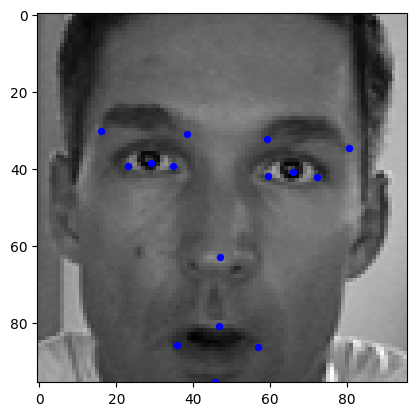

In [50]:
for img, keypoint in facial_keypoints_train_dataset_loaded.skip(1).take(1).as_numpy_iterator():
    print(f"{'Check Train Data'.center(61, '=')}")
    print(f'''    shape img: {img.shape}
    dtype img: {img.dtype}
    max intensity: {tf.reduce_max(img)}
    min intensity: {tf.reduce_min(img)}

    keypoint: {keypoint}
    keypoint-shape: {keypoint.shape}
    image-type: {keypoint.dtype}
    max-value: {tf.reduce_max(keypoint)}
    min-value: {tf.reduce_min(keypoint)}'''
    )

    for i in range(0, len(keypoint), 2):
        x = keypoint[i]
        y = keypoint[i+1]
        plt.scatter(x, y, s=75, marker='.', c='blue')
    plt.imshow(img, cmap='gray')
plt.show()

==========================Check data=========================
    shape img: (96, 96, 1)
    dtype img: float32
    max intensity: 0.9686274528503418
    min intensity: 0.007843137718737125
    keypoint value: [65.9606069  40.89997241 29.05555862 38.51917241 59.41274483 41.79244138
 72.21053793 42.09037241 34.71028966 39.41164138 23.10355862 39.41164138
 59.11547586 32.26857931 80.544      34.65004138 38.28215172 31.07817931
 15.96049655 30.18571034 46.91288276 62.92369655 56.73401379 86.43575172
 35.90068966 85.84055172 46.61495172 80.78102069 45.72248276 95.36441379]
    dtype keypoint: float64


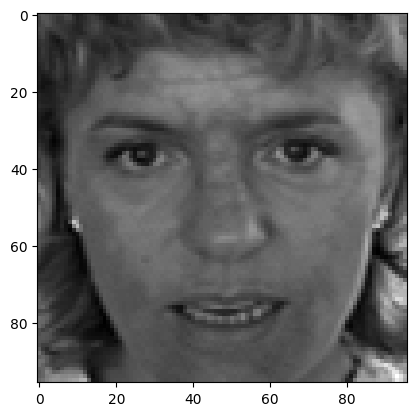

In [51]:
for img in facial_keypoints_test_dataset_loaded.skip(1).take(1).as_numpy_iterator():
    print(f"{'Check Test Data'.center(61, '=')}")
    print(f'''    shape img: {img.shape}
    dtype img: {img.dtype}
    max intensity: {tf.reduce_max(img)}
    min intensity: {tf.reduce_min(img)}
    keypoint value: {keypoint}
    dtype keypoint: {keypoint.dtype}'''
    )
    plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
def processed_image(image, keypoint):
    image = tf.cast(image, tf.float32)
    image = image / tf.reduce_max(image)
    return image, keypoint

facial_keypoints_datasets_processed = facial_keypoints_train_dataset_loaded.map(processed_image, num_parallel_calls=tf.data.AUTOTUNE)
facial_keypoints_datasets_cached = facial_keypoints_datasets_processed.cache()

In [ ]:
for img, keypoint in facial_keypoints_datasets_cached.skip(10).take(1).as_numpy_iterator():
    print(f"{'Check data'.center(61, '=')}")
    print(f'''    shape img: {img.shape}
    dtype img: {img.dtype}
    max intensity: {tf.reduce_max(img)}
    min intensity: {tf.reduce_min(img)}

    keypoint: {keypoint}
    keypoint-shape: {keypoint.shape}
    image-type: {keypoint.dtype}
    max-value: {tf.reduce_max(keypoint)}
    min-value: {tf.reduce_min(keypoint)}'''
    )

    for i in range(0, len(keypoint), 2):
        x = keypoint[i]
        y = keypoint[i+1]
        plt.scatter(x, y, s=75, marker='.', c='blue')
    plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
facial_keypoints_concatenated_train_dataset_shuffled = facial_keypoints_datasets_cached.shuffle(len(facial_keypoints_train_dataset_loaded))

train_size=int(0.9*len(facial_keypoints_concatenated_train_dataset_shuffled))
# ============================== Training ==============================
facial_keypoints_train_dataset = facial_keypoints_concatenated_train_dataset_shuffled.take(train_size)
facial_keypoints_train_dataset_batched = facial_keypoints_train_dataset.batch(64)
facial_keypoints_train_dataset_prefetched = facial_keypoints_train_dataset_batched.prefetch(tf.data.AUTOTUNE)

# ================================ Test ================================
facial_keypoints_valid_dataset = facial_keypoints_concatenated_train_dataset_shuffled.skip(train_size)
facial_keypoints_valid_dataset_batched = facial_keypoints_valid_dataset.batch(64)
facial_keypoints_valid_dataset_prefetched = facial_keypoints_valid_dataset_batched.prefetch(tf.data.AUTOTUNE)

In [ ]:
print(f'Training Dataset')
print(f'Info data: {facial_keypoints_train_dataset}')
print(f'Number of data: {len(facial_keypoints_train_dataset)}')
print(f'=================================== After Batched ===================================')
print(f'Number of data: {len(facial_keypoints_train_dataset_prefetched)}')

print(f'Test Dataset')
print(f'Info data: {facial_keypoints_valid_dataset}')
print(f'Number of data: {len(facial_keypoints_valid_dataset)}')
print(f'=================================== After Batched ===================================')
print(f'Number of data: {len(facial_keypoints_valid_dataset_prefetched)}')

In [ ]:
facial_keypoints_concatenated_test_dataset_batched = facial_keypoints_test_dataset_loaded.batch(64)
facial_keypoints_concatenated_test_dataset_prefetched = facial_keypoints_concatenated_test_dataset_batched.prefetch(tf.data.AUTOTUNE)

In [186]:
# def masked_mse(y_true, y_pred):
#     mask = tf.not_equal(y_true, 0)  # Masker untuk nilai yang tidak nol (keypoint yang tersedia)
#     mask = tf.cast(mask, tf.float32)  # Konversi ke float
#     loss = tf.square(y_true - y_pred) * mask  # Hitung MSE hanya pada keypoint yang tersedia
#     loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)  # Rata-rata loss berdasarkan jumlah keypoint yang tersedia
#     return loss

def masked_mse_loss(y_true, y_pred):
    # Create a mask based on the true labels
    mask = tf.where(tf.greater(y_true, 0), tf.ones_like(y_true), tf.zeros_like(y_true))
    # Compute the mean squared error
    mse = tf.square(y_true - y_pred)
    # Apply the mask to the mse
    masked_mse = mse * mask
    # Compute the mean of the masked mse
    return tf.reduce_mean(masked_mse)

def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)
    return x

def build_ml_resnet(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Initial Conv Layer
    x = tf.keras.layers.Conv2D(32, (11, 11), strides=1, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    # Residual Blocks
    for _ in range(2):
        x = residual_block(x, 32)

    # Fully Connected Layer
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30)(x)  # 15 keypoints (x, y) coordinates

    model = tf.keras.models.Model(inputs, outputs)
    return model

model = build_ml_resnet((96, 96, 1))
model.compile(optimizer='adam', loss=masked_mse_loss, metrics=['mae'], run_eagerly=True)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 96, 96, 1)]          0         []                            
                                                                                                  
 conv2d_30 (Conv2D)          (None, 96, 96, 32)           3904      ['input_7[0][0]']             
                                                                                                  
 batch_normalization_30 (Ba  (None, 96, 96, 32)           128       ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_30 (ReLU)             (None, 96, 96, 32)           0         ['batch_normalization_30

In [187]:
data_train, data_test = tf.keras.utils.split_dataset(
    face_images_tf_dataset_fixed_loaded_sobel, 
    right_size=0.2, 
    shuffle=True, 
    seed=42
)

In [188]:
data_train.cardinality(), data_test.cardinality()

(<tf.Tensor: shape=(), dtype=int64, numpy=11278>,
 <tf.Tensor: shape=(), dtype=int64, numpy=2820>)

In [190]:
data_train_repeated = data_train.batch(64).repeat()
data_test_repeated = data_test.batch(64).repeat()

In [191]:
train_steps = 11278 // 64
valid_steps = 2820 // 64

# Assuming `train_images` and `train_keypoints` are your training data and labels
model.fit(
    data_train_repeated,
    steps_per_epoch=train_steps,
    validation_data=data_test_repeated, 
    validation_steps=valid_steps,
    epochs=5, 
)

Epoch 1/5
176/176 [==============================] - 215s 1s/step - loss: 652.2166 - mae: 30.3732 - val_loss: 247.5492 - val_mae: 24.1231
Epoch 2/5
176/176 [==============================] - 228s 1s/step - loss: 261.1637 - mae: 28.9620 - val_loss: 109.6081 - val_mae: 25.0927
Epoch 3/5
176/176 [==============================] - 227s 1s/step - loss: 245.1749 - mae: 28.6649 - val_loss: 82.3343 - val_mae: 25.9076
Epoch 4/5
176/176 [==============================] - 227s 1s/step - loss: 236.7566 - mae: 28.7163 - val_loss: 126.8526 - val_mae: 24.8545
Epoch 5/5
176/176 [==============================] - 226s 1s/step - loss: 239.1377 - mae: 28.5912 - val_loss: 107.6256 - val_mae: 25.0890


In [47]:
# import re

# # List of column names
# facial_key_points_columns=samples_test.drop(columns='Image').columns

# # Function to reverse the suffixes using regex
# def reverse_suffix(column_name):
#     return re.sub(r'(x|y)$', lambda match: 'y' if match.group(1).lower() == 'x' else 'x', column_name, flags=re.IGNORECASE | re.MULTILINE)

# # Apply the function to each column name
# facial_key_points_columns_reversed = [reverse_suffix(column) for column in facial_key_points_columns]

# # Print the result
# print(f'original: {facial_key_points_columns}')
# print(f'reversed: {facial_key_points_columns_reversed}')

# rename_columns = result = {key: value for key, value in zip(facial_key_points_columns, facial_key_points_columns_reversed)}
# samples_test_revesed.rename(columns=rename_columns, inplace=True)

#### langkah Uji Coba sebelum di ubah menjadi tensorflow datasets:
1. ambil 2 sampel untuk dijadikan percobaan, lalu buat copy dari 2 sampel tersebut gambar beserta facial-keypointnya.
2. setelah di copy maka akan ada 4 gambar dengan 2 gambar dan facial-keypoitnya yang sama.
3. 2 hasil gambar yang di copy lalu di flip secara horizontal untuk di augmentasi.
4. namun untuk facial key-pointya masih belum tercopy, sehingga koordinatnya masih salah.
5. maka perlu di atur dengan menukar sumbu x menjadi y dan y menjadi x.

#### langkah jika berhasil:
1. jika berhasil maka, terapkan untuk seluruh gambar dan facial keypointsnya, dengan kondisi facial keypoinnya suda terflip.
2. sehingga total data menjadi 2 kali lipat dari data asli, namun kondisi gambar pada data copy masih belum terflip.
3. setelah diubah menjadi tensorflow datasets maka gambar pada data copy di flip, dengan melakukan slicing index pada data copy. untuk diterapkannya flip horizontal.
4. jika gagal, maka cari cara lain.

#### validasi hasil preprocessing:
1. menampilkan gambar copy yang sudah terflip beserta facial keypointnya dengan data asli, untuk mengetahui langkah telah sukses.
